# Exame Final - Ciência de Dados e Cibersegurança

Prezados(as),

Esta é uma das questões do exame final da disciplina “Ciência de Dados e Segurança”.

A atividade é baseada em um exercício de Capture the Flag (CTF) da Trendmicro: Wildcard 400 do CTF 2019 da Trendmicro.

## Dataset

Vocês deverão utilizar o seguinte conjunto de dados:
gowiththeflow_20190826.cvs

O dataset está disponível em:
https://www.kaggle.com/datasets/hawkcurry/2019-trendmicro-ctf-wildcard-400

Para prosseguir:
Baixem o dataset.
Carreguem os dados em um notebook no Kaggle.

## Objetivo

O propósito deste exame é verificar o aprendizado individual dos conceitos vistos em aula. Por isso, cada aluno deve realizar o exame sozinho, refletindo sobre os resultados e, quando necessário, consultando os manuais de Python para comandos específicos.

Esta atividade foi inspirada em exercícios semelhantes encontrados na literatura científica.

## Tarefas

Considerem a introdução e o contexto apresentados no enunciado.

Analisem o dataset conforme solicitado (as questões e etapas práticas serão disponibilizadas no roteiro da atividade).

Registrem suas respostas em um notebook no Kaggle.

## Entrega

Façam uma cópia do notebook com o enunciado da atividade.
Realizem os exercícios no seu próprio notebook.
Compartilhem o link público do notebook com suas respostas como forma de entrega.

## Atenção
Cópias não serão toleradas. 

*Introdução*

Imagine que você é um(a) administrador(a) de segurança de rede de uma empresa chamada MAYOcorp. Seu trabalho é utilizar dados de fluxos de rede (network flow data) para identificar eventos de segurança anômalos.

Este exame traz uma amostra de dados agregados sobre fluxos de rede e utiliza as respostas relacionadas aos eventos anômalos para a construção da flag.

*Estrutura*

Esta questão do exame contém quatro sub perguntas, com valor total máximo de 16 pontos.
Cada questão vale, no máximo, 4 pontos.

Utilize, sempre que possível, as ferramentas vistas em sala, como gráficos e visualizações de dados, para apoiar suas respostas.

Observação: Não é necessário ter conhecimento prévio aprofundado de segurança de redes ou protocolos para realizar este exame.

*Informações gerais sobre os dados*

O dataset contém os seguintes campos:

Timestamp – registro temporal do fluxo de rede.
src – endereço IP de origem.
dst – endereço IP de destino.
port – porta utilizada na comunicação.
bytes – quantidade de bytes transferidos.

Regras para classificação de hosts:
Hosts internos: possuem endereços IP que começam com 12, 13 ou 14.
Hosts externos: todos os outros endereços IP.
  


In [1]:
import gc
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Função reaproveitada dos TP
def barplot(df, x, y, xlab=None, ylab=None, title=None, order_desc=False, figsize=(8, 6)):
  if order_desc:
      # Ordena o DataFrame pelo y em ordem decrescente
      df_sorted = df.sort_values(by=y, ascending=False)
      order = df_sorted[x].tolist()
  else:
      order = None

  fig, ax = plt.subplots(figsize=figsize)
  bar = sns.barplot(df, x=x, y=y, ax=ax, order=order)

  bars = bar.containers[0]
  bar_qtd = [rect.get_height() for rect in bars]
  labels = [f'{v:.0f} ({v/(sum(bar_qtd)):.1%})' for v in bar_qtd]
  ax.bar_label(bars, labels=labels, padding=5)

  sns.despine(offset=10)
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab);

In [3]:
%%time
path = '/kaggle/input/2019-trendmicro-ctf-wildcard-400/gowiththeflow_20190826.csv'
df = pd.read_csv(
    path, 
    header=None,
    names=['ts', 'src', 'dst', 'port', 'bytes'],
    low_memory=False
)

CPU times: user 1min 17s, sys: 24 s, total: 1min 41s
Wall time: 2min 40s


*Sub pergunta #1: Apresente as etapas exploratórias que você seguiria para conhecer o conjunto de dados considerando a possibilidade de classificar o tráfego de rede como “tráfego de entrada (inbound traffic)” e “tráfego de saída (outbound traffic)”. Lembre-se: os hosts internos possuem endereços IP iniciando com 12 a 14.
Seja o mais completo e detalhado possível.* 

Para um melhor compreensão do conjunto de dados eu seguiria algumas etapas iniciais de análise exploratórias, a fim de verificar a viabilidade e qualidade desses dados. Sendo elas:

- Verificação de valores nulos
- Tipo de cada coluna e consumo dos dados
- Caso seja um dataset de tamanho extenso (que é o nosso caso), aplica-se transformações dos tipos da coluna
- Aplicação de transformações para ter de forma fácil os tráfegos Inbound e Outbound
- Verificação da distribuição do total de linhas Outbound e Inbound
- Estatistíca descritiva geral do conjunto de dados para a coluna de bytes

In [4]:
%%time
df.isna().sum()

CPU times: user 10.9 s, sys: 149 ms, total: 11 s
Wall time: 11 s


ts       0
src      0
dst      0
port     0
bytes    0
dtype: int64

In [5]:
%%time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105747730 entries, 0 to 105747729
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ts      int64 
 1   src     object
 2   dst     object
 3   port    int64 
 4   bytes   int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ GB
CPU times: user 11.3 ms, sys: 2.23 ms, total: 13.6 ms
Wall time: 24.5 ms


In [6]:
# Transformações para otimização da memória e análises futuras
df['hour'] = pd.to_datetime(df['ts'], unit='ms').dt.hour
df['port'] = df['port'].astype('int8')
df['src'] = df['src'].astype('category')
df['dst'] = df['dst'].astype('category')

gc.collect()

17

In [7]:
# df.info()
# Redução de mais de 2GB

In [8]:
# Criando as colunas de classificação do tráfego - mexendo direto com categoria para não estourar a memória
src_cats = df['src'].cat.categories
dst_cats = df['dst'].cat.categories

internal_src_mask = src_cats.str.match(r'^1[234]\.')
internal_dst_mask = dst_cats.str.match(r'^1[234]\.')

internal_src_ips = src_cats[internal_src_mask]
internal_dst_ips = dst_cats[internal_dst_mask]

src_is_internal = df['src'].isin(internal_src_ips)
dst_is_internal = df['dst'].isin(internal_dst_ips)

conditions = [
    (src_is_internal & ~dst_is_internal),  
    (~src_is_internal & dst_is_internal),    
    (src_is_internal & dst_is_internal),    
    (~src_is_internal & ~dst_is_internal)   
]

classes = ['outbound', 'inbound', 'internal', 'external']

df['traffic_type'] = pd.Categorical(np.select(conditions, classes)) # Mantive em inglês para seguir o padrão do DF

del src_is_internal, dst_is_internal # Economizar memória
gc.collect() # Economizar memória

0

  traffic_type     count
0      inbound  47690506
1     outbound  38598645
2     internal  19458579 



108

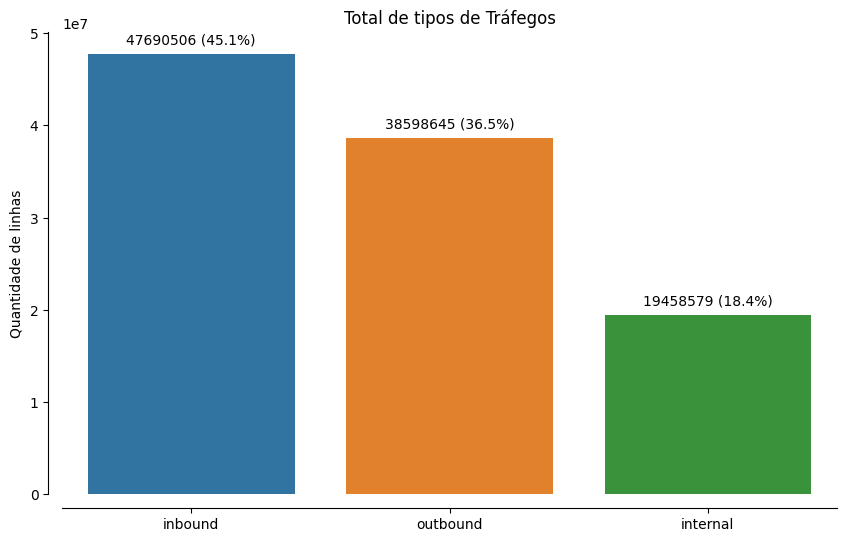

In [9]:
df_temp = df['traffic_type'].value_counts().to_frame().reset_index()
print(df_temp, "\n")

barplot(
    df_temp,
    x='traffic_type',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tipos de Tráfegos",
    order_desc=True,
    figsize=(10, 6)
)

del df_temp
gc.collect()

In [10]:
# Estatística descritiva para verificar o comportamento do bytes por tráfego Outboun e Inbound
display(df[df['traffic_type'] == 'outbound'][['bytes']].describe().T)
display(df[df['traffic_type'] == 'inbound'][['bytes']].describe().T)

gc.collect()

,count,mean,std,min,25%,50%,75%,max
bytes,38598645.0,18261.392666,27440.463445,21.0,984.0,1500.0,30748.0,843091.0


,count,mean,std,min,25%,50%,75%,max
bytes,47690506.0,27408.653804,27151.737894,21.0,6075.0,15481.0,45339.0,209446.0


2653

Aqui já temos uam visão que o Tráfego Outbound tem uma transferência de dados muito maior do que os Inboud, o que já era esperado.

## Specific analysis

### Vazamento de dados

*Sub pergunta #2: Considere que sua propriedade intelectual está saindo do edifício, ou seja, uma máquina interna está sendo usada para enviar todos os seus projetos e informações sigilosas. Um dos hosts está enviando muito mais dados da empresa do que os demais. Qual é o endereço IP desse host?*


Média de bytes enviados: 114222170.27

Desvio Padrão: 315401300.70

Os 10 Host Mais Suspeitos: src
13.37.84.125    10625497574
13.48.72.30      1727525696
14.51.75.107     1656207638
14.51.30.86      1647330708
12.59.25.34      1617316039
12.56.32.111     1600604429
14.57.50.29      1589314261
13.39.46.94      1576854685
12.58.68.102     1545945975
12.45.94.34      1501437235
12.37.36.110     1493709910
Name: bytes, dtype: int64


144

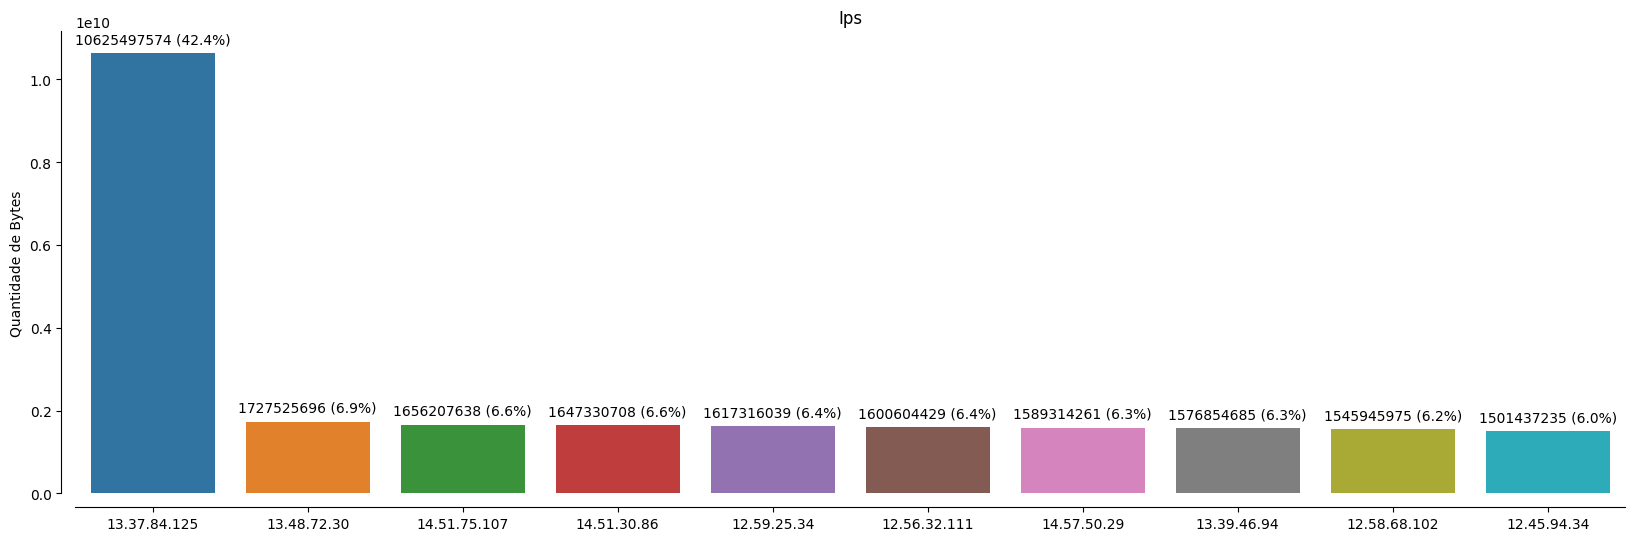

In [11]:
outbound_mask = (df['traffic_type'] == 'outbound')
outbound_data = df[outbound_mask] 

bytes_host = outbound_data.groupby('src')['bytes'].sum().sort_values(ascending=False)

# Pegandos os hosts com o volume muito acima de média
mean_bytes = bytes_host.mean()
std_bytes = bytes_host.std()

valor_corte = mean_bytes + (3 * std_bytes)
hosts_suspeitos = bytes_host[bytes_host > valor_corte]

print(f"\nMédia de bytes enviados: {mean_bytes:.2f}")
print(f"\nDesvio Padrão: {std_bytes:.2f}")
print(f"\nOs 10 Host Mais Suspeitos: {hosts_suspeitos[0:11]}") # Host mais suspeito 13.37.84.125

ip_q2 = '13.37.84.125'

df_temp = bytes_host.to_frame().reset_index()

barplot(
    df_temp.head(10),
    x='src',
    y='bytes',
    ylab="Quantidade de Bytes",
    title="Ips",
    order_desc=True,
    figsize=(20, 6)
)

del df_temp
gc.collect()

Nosso IP suspeito é o `13.37.84.125`.

*Sub pergunta #3: Outro atacante agendou uma tarefa para exportar o conteúdo do seu wiki interno. Um dos hosts está enviando muito mais dados fora do horário comercial da empresa do que os demais, diferente do host da Questão 3. Qual é o endereço IP desse host?* 

Ip Suspeito: 13.48.72.30



4326

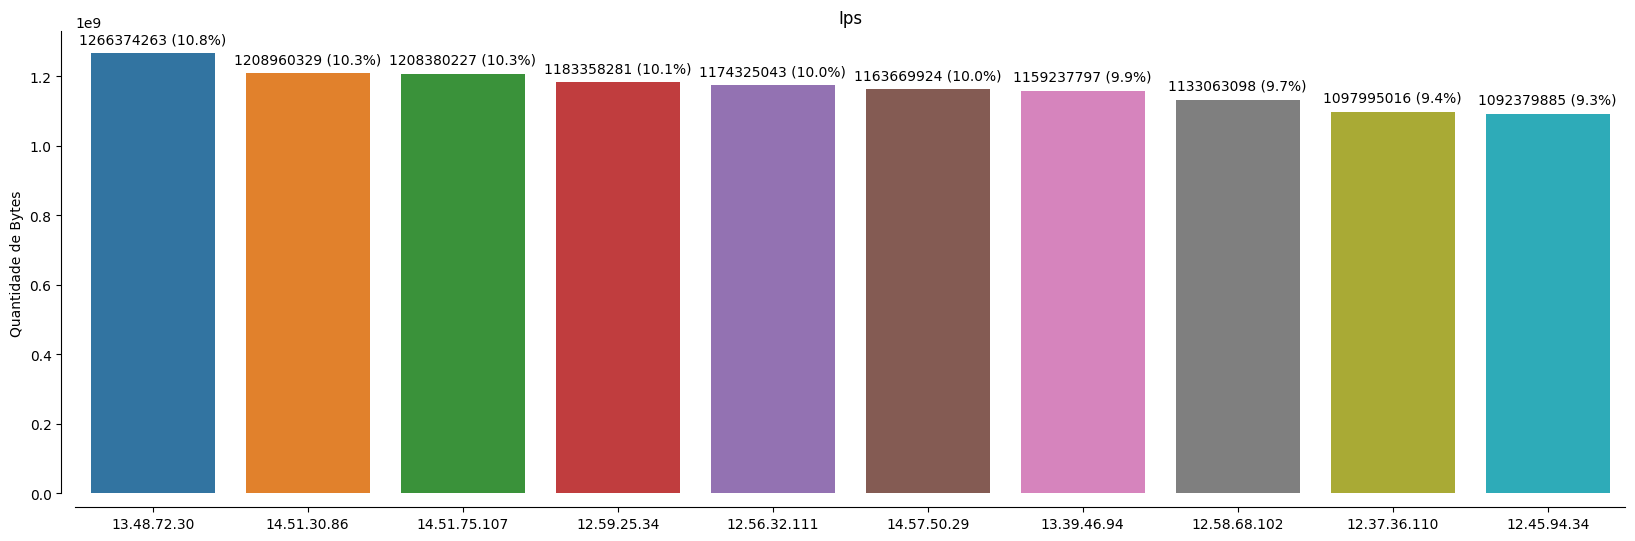

In [12]:
no_bussines_hour = df[(df['traffic_type'] == 'outbound') & 
                      ((df['hour'] < 8) | (df['hour'] > 17)) & # Considerei o horario comercial de 8h às 17h
                      (df['src'] != ip_q2)
]

ip_q3 = no_bussines_hour.groupby('src')['bytes'].sum().idxmax()

print(f"Ip Suspeito: {ip_q3}\n")

df_temp = no_bussines_hour.groupby('src')['bytes'].sum().reset_index().sort_values('bytes', ascending=False)

barplot(
    df_temp.head(10),
    x='src',
    y='bytes',
    ylab="Quantidade de Bytes",
    title="Ips",
    order_desc=True,
    figsize=(20, 6)
)

del df_temp
gc.collect()

Nosso IP suspeito é o `13.48.72.30`.

*Sub pergunta 4: Algum invasor está coletando todos os endereços de e-mail de funcionários e fornecedores e os enviando por um canal normalmente reservado para outros usos. Isso é semelhante a atacantes abusando do DNS para exfiltração (vazamento) de dados. Um dos hosts está enviando muito mais dados em uma determinada porta da empresa do que os outros hosts, diferente dos hosts das sub perguntas 2 e 3. Qual é essa porta?*


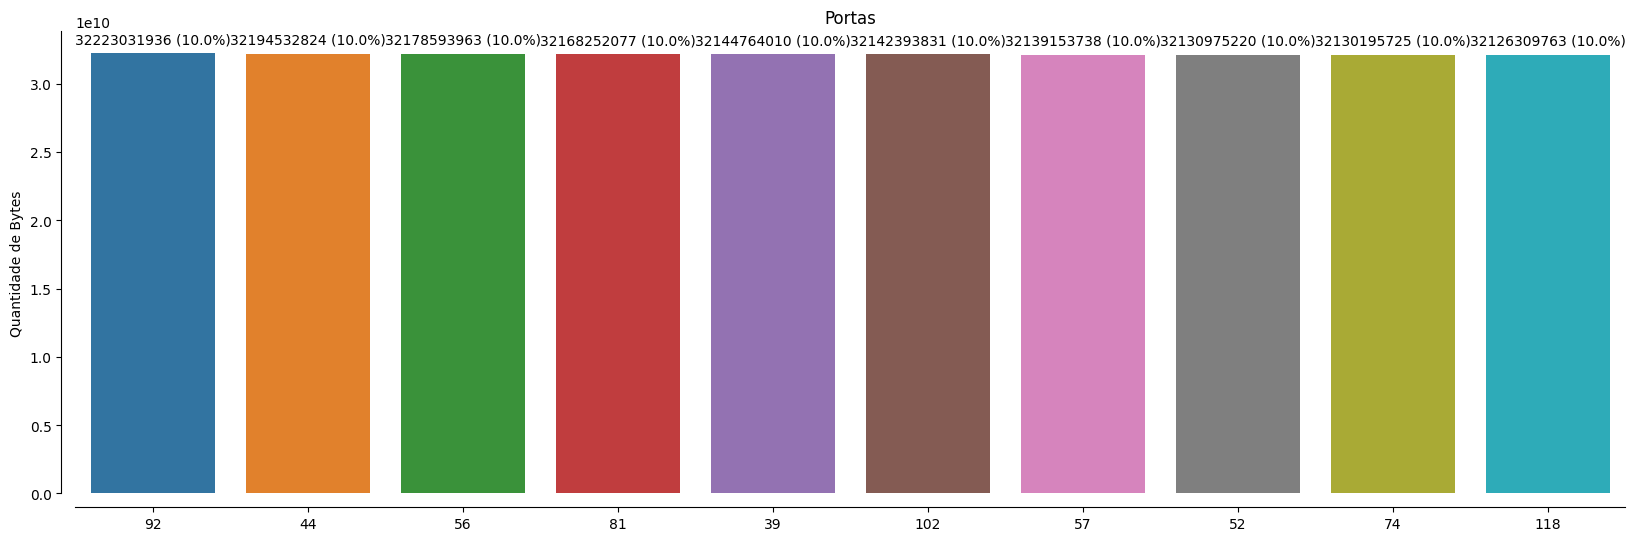

In [13]:
port_outbound = df[(df['traffic_type'] == 'outbound') & 
                   (~df['src'].isin([ip_q2, ip_q3]))
]

df_temp = port_outbound.groupby(['port'])['bytes'].sum().reset_index().sort_values('bytes', ascending=False).reset_index(drop=True)

barplot(
    df_temp.head(10),
    x='port',
    y='bytes',
    ylab="Quantidade de Bytes",
    title="Portas",
    order_desc=True,
    figsize=(20, 6)
)

In [14]:
top_10_ports = df_temp['port'].head(10).to_list()

# Verificando a concentração de Ips por portas
for port in top_10_ports:
    port_data = port_outbound[port_outbound['port'] == port]
    
    # Verificando quem mais envia nesta porta
    top_ip = port_data.groupby('src')['bytes'].sum().nlargest(2)
    
    if len(top_ip) > 0:
        concentration = top_ip.iloc[0] / port_data['bytes'].sum()
        
        print(f"\nPorta {port}:")
        print(f"Top host: {top_ip.index[0]}")
        print(f"Concentração: {concentration:.1%}")
        
        # Se tem >80% do tráfego da porta, podemos considerar suspeito
        if concentration > 0.8:
            print(f"Alta concentração, suspeito!")


Porta 92:
Top host: 14.51.30.86
Concentração: 0.2%

Porta 44:
Top host: 14.57.50.29
Concentração: 0.2%

Porta 56:
Top host: 14.57.50.29
Concentração: 0.2%

Porta 81:
Top host: 14.51.75.107
Concentração: 0.2%

Porta 39:
Top host: 14.51.75.107
Concentração: 0.3%

Porta 102:
Top host: 14.51.75.107
Concentração: 0.3%

Porta 57:
Top host: 14.51.30.86
Concentração: 0.2%

Porta 52:
Top host: 14.51.30.86
Concentração: 0.2%

Porta 74:
Top host: 14.51.30.86
Concentração: 0.2%

Porta 118:
Top host: 14.51.75.107
Concentração: 0.2%


In [15]:
# Verificando agora para todas as portas
for port in port_outbound['port'].unique():
    port_data = port_outbound[port_outbound['port'] == port]
    
    # Verificando quem mais envia nesta porta
    top_ip = port_data.groupby('src')['bytes'].sum().nlargest(2)
    
    if len(top_ip) > 0:
        concentration = top_ip.iloc[0] / port_data['bytes'].sum()
        
        # Se tem >80% do tráfego da porta, podemos considerar suspeito
        if concentration > 0.8:
            print(f"\nPorta {port}:")
            print(f"Top host: {top_ip.index[0]}")
            print(f"Concentração: {concentration:.1%}")
            print(f"Alta concentração, suspeito!")
            print(f"Posição no Rank: {df_temp[df_temp['port'] == port].index[0]}")


Porta 31:
Top host: 12.55.77.96
Concentração: 100.0%
Alta concentração, suspeito!
Posição no Rank: 40


Aqui conseguimos ver que o nosso IP suspeito é o `12.55.77.96` e que sua concentração é na porta `31`. É possível notar que sua posição é no 40 no rank, quando olhamos o somatório do total de Bytes. Quando olhamos apenas uma características temos que tomar o cuidado para não deixar passar batido como essa.

Dica: Para problemas como este, às vezes temos informações ou experiências prévias que podem nos ajudar a começar. Por exemplo, portas nas quais esperamos alto volume de tráfego de saída, como 443 e 80, e aquelas nas quais não esperamos tráfego de alta saída, como a 53. Também existe a noção de portas com uso comum e incomum. No entanto, ao observar os dados, parece que nada disso é aplicável.